In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import linregress
from scipy.optimize import minimize
from lifelines import WeibullFitter
from lifelines.utils import concordance_index


In [50]:
df = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')

In [51]:
kmf = KaplanMeierFitter()
kmf.fit(df['time'], event_observed=df['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 686 total observations, 387 right-censored observations>

In [52]:
time_points = kmf.survival_function_.index
survival_probs = kmf.survival_function_['KM_estimate']
log_log_survival = np.log(-np.log(survival_probs))
log_time = np.log(time_points)


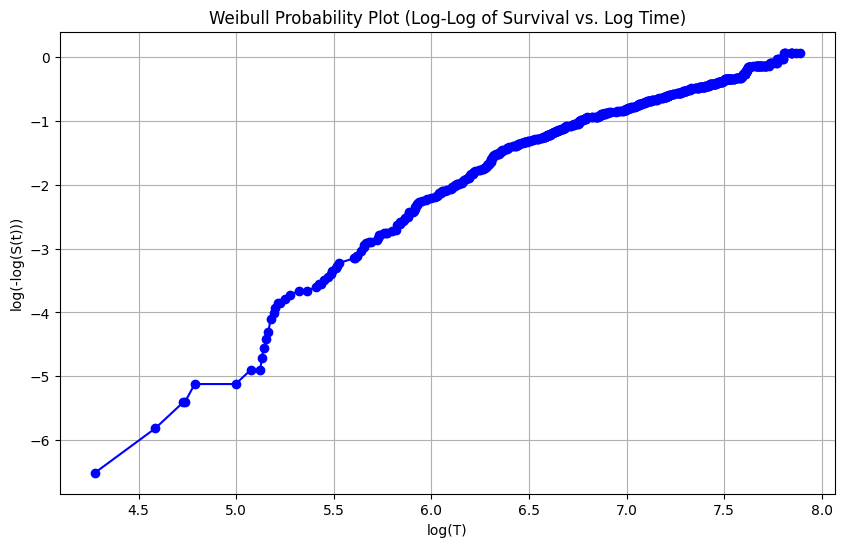

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(log_time, log_log_survival, marker='o', linestyle='-', color='blue')
plt.title('Weibull Probability Plot (Log-Log of Survival vs. Log Time)')
plt.xlabel('log(T)')
plt.ylabel('log(-log(S(t)))')
plt.grid(True)
plt.show()

In [54]:
def estimate_weibull_params(data, time_col='time', event_col='status'):
    # Fit the Kaplan-Meier estimator
    kmf = KaplanMeierFitter()
    kmf.fit(data[time_col], event_observed=data[event_col])

    # Transform the survival function
    time_points = kmf.survival_function_.index
    survival_probs = kmf.survival_function_['KM_estimate']
    log_log_survival = np.log(-np.log(survival_probs))
    log_time = np.log(time_points)

    # Filter out infinite values resulting from log(0)
    valid_idx = np.isfinite(log_log_survival) & np.isfinite(log_time)
    log_log_survival = log_log_survival[valid_idx]
    log_time = log_time[valid_idx]

    # Perform linear regression on the transformed data
    slope, intercept, _, _, _ = linregress(log_time, log_log_survival)

    # Calculate alpha and beta
    alpha = slope
    beta = np.exp(-intercept / alpha)

    # Plot the data and regression line for visualization
    plt.figure(figsize=(10, 6))
    plt.plot(log_time, log_log_survival, 'o', label='Transformed data')
    plt.plot(log_time, slope * log_time + intercept, 'r-', label=f'Fit line (alpha={alpha:.2f}, beta={beta:.2f})')
    plt.title('Weibull Probability Plot (Log-Log of Survival vs. Log Time)')
    plt.xlabel('log(T)')
    plt.ylabel('log(-log(S(t)))')
    plt.grid(True)
    plt.legend()
    plt.show()

    return alpha, beta

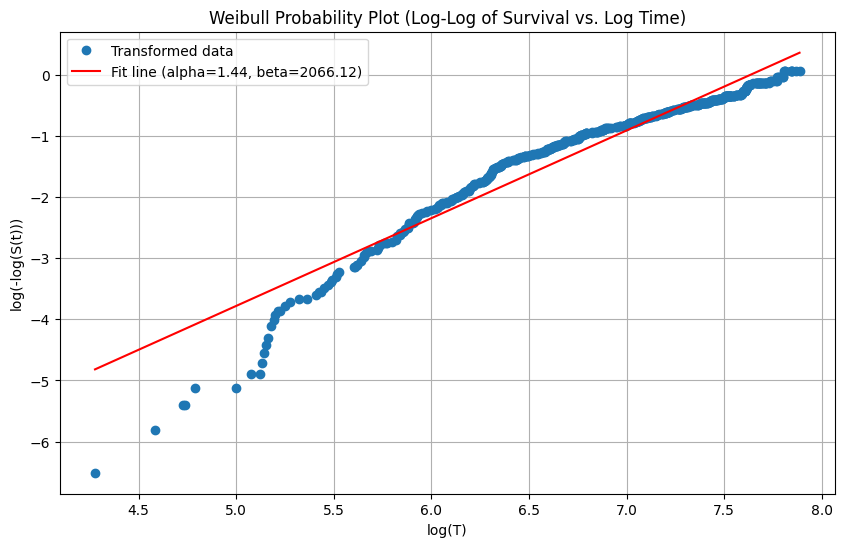

Estimated alpha (shape): 1.44
Estimated beta (scale): 2066.12


In [55]:
alpha_est, beta_est = estimate_weibull_params(df)
print(f"Estimated alpha (shape): {alpha_est:.2f}")
print(f"Estimated beta (scale): {beta_est:.2f}")

In [56]:
alpha = alpha_est  # Shape parameter
beta = beta_est   # Scale parameter

Predicted Median Survival Time: 1600.55


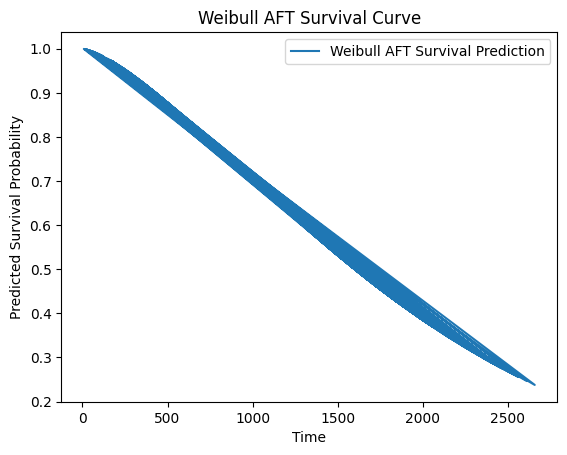

In [57]:
def weibull_aft_predict(t, alpha, beta):
    return np.exp(-(t / beta) ** alpha)

# Applying the Weibull AFT model to predict survival probabilities at different time points
df['predicted_survival'] = weibull_aft_predict(df['time'], alpha, beta)

# Example: Calculate the predicted median survival time (T at S=0.5)
predicted_median_survival = beta * (np.log(2)) ** (1 / alpha)
print(f"Predicted Median Survival Time: {predicted_median_survival:.2f}")

# Plot survival curve if needed
import matplotlib.pyplot as plt
plt.plot(df['time'], df['predicted_survival'], label="Weibull AFT Survival Prediction")
plt.xlabel("Time")
plt.ylabel("Predicted Survival Probability")
plt.title("Weibull AFT Survival Curve")
plt.legend()
plt.show()

In [58]:
# Calculate predicted times for each individual using their observed time as baseline
df['predicted_time'] = beta * (df['time'] / beta) ** (1 / alpha)

In [59]:
predicted_times = df['predicted_time'].values  # Convert to array for indexing
observed_times = df['time'].values             # Observed times
event_occurred = df['status'].values           # Status (1 for event, 0 for censored)

# Concordance calculation
concordant, discordant, tied = 0, 0, 0

for i in range(len(predicted_times)):
    for j in range(i + 1, len(predicted_times)):
        if event_occurred[i] != event_occurred[j]:  # Only compare if one has an event
            time_i, time_j = observed_times[i], observed_times[j]
            pred_time_i, pred_time_j = predicted_times[i], predicted_times[j]
            event_i, event_j = event_occurred[i], event_occurred[j]

            # Concordant pairs
            if (pred_time_i < pred_time_j and event_i == 1) or (pred_time_i > pred_time_j and event_j == 1):
                concordant += 1
            # Discordant pairs
            elif (pred_time_i > pred_time_j and event_i == 1) or (pred_time_i < pred_time_j and event_j == 1):
                discordant += 1
            # Tied pairs
            else:
                tied += 1

# Calculate the C-index
c_index = (concordant + 0.5 * tied) / (concordant + discordant + tied)
print(f"Manually Calculated Concordance Index (C-index): {c_index:.4f}")

Manually Calculated Concordance Index (C-index): 0.7651


In [60]:
def weibull_log_likelihood(alpha, beta, times, events):
    # Epsilon to prevent log(0) in calculations
    epsilon = 1e-10
    log_likelihood = 0

    for t, event in zip(times, events):
        if event == 1:  # Event observed
            log_likelihood += np.log((alpha / beta) * (t / beta) ** (alpha - 1)) - (t / beta) ** alpha
        else:  # Censored
            log_likelihood -= (t / beta) ** alpha

    return log_likelihood

# Assuming `df` is your DataFrame with columns `time` and `status`
# where `time` is survival time and `status` is event occurrence (1 = event, 0 = censored)

# Estimated parameters
alpha_est = 1.44  # Replace with your estimated alpha
beta_est = 2066.12  # Replace with your estimated beta

# Log-likelihood calculation
log_likelihood = weibull_log_likelihood(alpha_est, beta_est, df['time'].values, df['status'].values)

# Calculate AIC (2 parameters: alpha and beta)
k = 2
aic = 2 * k - 2 * log_likelihood
print(f"AIC for Weibull AFT model: {aic:.2f}")

AIC for Weibull AFT model: 5286.08
